# XGBoost miRNA
Runs XGBoostClassifer on miRNA data.  

Three datasets are analyzed using the XGBoost classifier:
* Sham and infeceted mice from all weeks; i.e., 8 week and 16 week datasets are merged.
* Sham and infected mice at 8 weeks.
* Sham and infected mice at 16 weeks.

In each dataset, there is a flag (named ‘infected’) that marks whether the mice came from the infected group or the sham group.  
XGBoost's variable importance and SHAP values are then used to determine which miRNA variable was most important in each cohort dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# supress sklearn warnings (hopefully)
import os
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, roc_auc_score, roc_curve, mean_absolute_error
from IPython.display import display
import random
import shap

from util import make_mirna_nanostring_df, make_study_df, param_search, param_search_cv, \
    plot_shap_feature_importance, plot_xgb_feature_importance, combine_shap_heatmaps, \
    plot_shap_summary, plot_shap_heatmap, plot_shap_dependence, plot_shap_importance_with_summary, top_shap_values

In [4]:
! python --version

Python 3.10.12


In [5]:
print('xgboost version', xgb.__version__)
print('sklearn version', sklearn.__version__)
print('shap version', shap.__version__)

xgboost version 3.0.4
sklearn version 1.7.1
shap version 0.48.0


---

## load miRNA data

In [6]:
file_names = [
    '../data/Treponema_denticola/8 weeks T. denticola bacteria infection and NanoString miRNA data.csv', 
    '../data/Treponema_denticola/8 weeks SHAM NanoString Data td.csv', 
    '../data/Treponema_denticola/16 weeks T. denticola bacteria infection and NanoString miRNA data.csv', 
    '../data/Treponema_denticola/16 weeks SHAM NanoString Data td.csv'
]
cohort_names = ['td_8_weeks', 'sham_8_weeks', 'td_16_weeks', 'sham_16_weeks']
list(zip(file_names, cohort_names))

[('../data/Treponema_denticola/8 weeks T. denticola bacteria infection and NanoString miRNA data.csv',
  'td_8_weeks'),
 ('../data/Treponema_denticola/8 weeks SHAM NanoString Data td.csv',
  'sham_8_weeks'),
 ('../data/Treponema_denticola/16 weeks T. denticola bacteria infection and NanoString miRNA data.csv',
  'td_16_weeks'),
 ('../data/Treponema_denticola/16 weeks SHAM NanoString Data td.csv',
  'sham_16_weeks')]

In [7]:
miRNA_df = make_mirna_nanostring_df(file_names, cohort_names)
miRNA_df.shape

(40, 604)

## create dataframes and X, y datasets

In [8]:
df_8_weeks = make_study_df(miRNA_df, cohort_str='8_weeks', infected_str='td_')
df_16_weeks = make_study_df(miRNA_df, cohort_str='16_weeks', infected_str='td_')
df_all_weeks = make_study_df(miRNA_df, infected_str='td_')

In [9]:
X_8_weeks, y_8_weeks = df_8_weeks.drop('infected', axis=1), df_8_weeks['infected']
X_16_weeks, y_16_weeks = df_16_weeks.drop('infected', axis=1), df_16_weeks['infected']
X_all_weeks, y_all_weeks = df_all_weeks.drop('infected', axis=1), df_all_weeks['infected']

---

## search for best params

In [10]:
# see https://medium.com/grabngoinfo/hyperparameter-tuning-for-xgboost-91449869c57e
# see https://medium.com/@rithpansanga/the-main-parameters-in-xgboost-and-their-effects-on-model-performance-4f9833cac7c
# n_estimators: Number of trees in random forest
# max_depth: Maximum number of levels in tree
# tree_method: Tree construction algorithm used in XGBoost
# colsample_bytree: Percentage of columns to be randomly samples for each tree.
# eta: Learning rate
# gamma: Minimum loss reduction required to make further partition
# reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
# reg_lambda provides l2 regularization to the weight, higher values result in more conservative models

random_grid = {
    "objective": ["binary:logistic"],
    "n_estimators": list(range(25, 1001, 25)), # [25, 50, 75, ... 1000],
    "booster": ["gbtree"], # note TreeExplainer only supports gbtree
    "learning_rate": [0.1, 0.3, 0.5, 0.7, 0.9, 1],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    'max_depth': list(range(10, 201, 10)) + [None],# [10, 20, 30, ... 200, None],
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    # "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100], # not searching
    # "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100], # not seqarching
    'random_state': list(range(0, 9, 10)) # [0, 3, 6, 9]
}

In [11]:
# used for testing single param search
param_search(random_grid, X_8_weeks, y_8_weeks, xgb.XGBClassifier, cv=5)

{'booster': 'gbtree',
 'colsample_bytree': 0.6,
 'gamma': 0.1,
 'learning_rate': 0.9,
 'max_depth': 120,
 'n_estimators': 975,
 'objective': 'binary:logistic',
 'random_state': 0}


{'random_state': 0,
 'objective': 'binary:logistic',
 'n_estimators': 975,
 'max_depth': 120,
 'learning_rate': 0.9,
 'gamma': 0.1,
 'colsample_bytree': 0.6,
 'booster': 'gbtree'}

#### this code block takes a while to run, uncomment to run it

In [13]:
 #cv_range = range(2, 11)
 cv_range = range(2,5)
 clf = xgb.XGBClassifier
 
 print('** 8 weeks params **')
 params_8_weeks_cv = \
     param_search_cv(
         random_grid, X_8_weeks, y_8_weeks, clf, cvs=cv_range, print_best=True)
 
 print('** 16 weeks params **')
 params_16_weeks_cv = \
     param_search_cv(
         random_grid, X_16_weeks, y_16_weeks, clf, cvs=cv_range, print_best=True)
 
 print('** All weeks params **')
 params_all_weeks_cv = \
     param_search_cv(
         random_grid, X_all_weeks, y_all_weeks, clf, cvs=cv_range, print_best=True)

** 8 weeks params **
{'cv': 3,
 'params': {'booster': 'gbtree',
            'colsample_bytree': 0.4,
            'gamma': 0.2,
            'learning_rate': 1,
            'max_depth': 10,
            'n_estimators': 625,
            'objective': 'binary:logistic',
            'random_state': 0},
 'score': 0.95}
** 16 weeks params **
{'cv': 2,
 'params': {'booster': 'gbtree',
            'colsample_bytree': 0.7,
            'gamma': 0.4,
            'learning_rate': 0.3,
            'max_depth': 40,
            'n_estimators': 975,
            'objective': 'binary:logistic',
            'random_state': 0},
 'score': 0.9}
** All weeks params **
{'cv': 2,
 'params': {'booster': 'gbtree',
            'colsample_bytree': 0.3,
            'gamma': 0.0,
            'learning_rate': 0.1,
            'max_depth': 200,
            'n_estimators': 250,
            'objective': 'binary:logistic',
            'random_state': 0},
 'score': 0.625}


### assign best params

In [14]:
params_8_weeks = \
    {
        'booster': 'gbtree',
        'colsample_bytree': 0.6,
        'gamma': 0.2,
        'learning_rate': 0.5,
        'max_depth': 40,
        'n_estimators': 475,
        'objective': 'binary:logistic',
        'random_state': 0
    }

params_16_weeks = \
    {
        'booster': 'gbtree',
        'colsample_bytree': 0.4,
        'gamma': 0.3,
        'learning_rate': 0.1,
        'max_depth': 200,
        'n_estimators': 275,
        'objective': 'binary:logistic',
        'random_state': 0
    }

params_all_weeks = \
    {
        'booster': 'gbtree',
        'colsample_bytree': 0.6,
        'gamma': 0.2,
        'learning_rate': 0.5,
        'max_depth': 40,
        'n_estimators': 475,
        'objective': 'binary:logistic',
        'random_state': 0
    }

---

### compute XGBoost models

In [15]:
model_8_weeks = xgb.XGBClassifier(**params_8_weeks).fit(X_8_weeks, y_8_weeks)
model_16_weeks = xgb.XGBClassifier(**params_16_weeks).fit(X_16_weeks, y_16_weeks)
model_all_weeks = xgb.XGBClassifier(**params_all_weeks).fit(X_all_weeks, y_all_weeks)

---

### compute SHAP values (used for explainablity)

In [16]:
# need to change int and bool to classes int_ and bool_ to handle error 'numpy' has no attribute 'int'/'bool'/etc.
np.bool = np.bool_
np.int = np.int_
np.float = np.float64

In [18]:
explainer_8_weeks = shap.TreeExplainer(model_8_weeks, X_8_weeks, feature_names=X_8_weeks.columns.tolist())
shap_values_8_weeks = explainer_8_weeks(X_8_weeks)

explainer_16_weeks = shap.TreeExplainer(model_16_weeks, X_16_weeks, feature_names=X_16_weeks.columns.tolist())
shap_values_16_weeks = explainer_16_weeks(X_16_weeks)

explainer_all_weeks = shap.TreeExplainer(model_all_weeks, X_all_weeks, feature_names=X_all_weeks.columns.tolist())
shap_values_all_weeks = explainer_all_weeks(X_all_weeks)

---

## Bar and summary plots of feature importance
The XGBoost feature importance differs from the SHAP feature importance. They are measuring differently. See this [article](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27) for details.

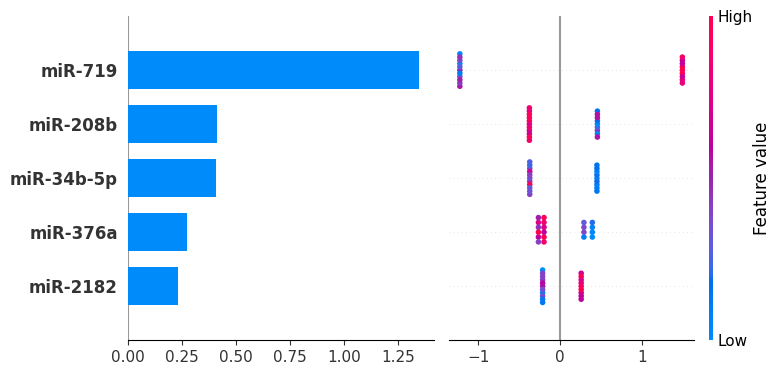

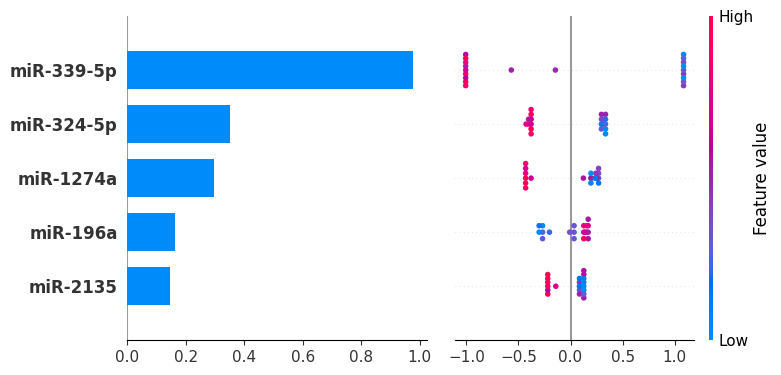

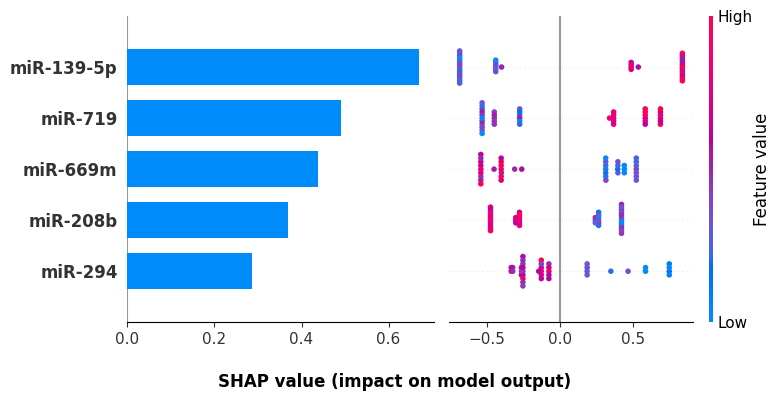

In [19]:
plot_shap_importance_with_summary(
    shap_values_8_weeks, 
    X_8_weeks, 
    title='',
    save_fig=True,
    file_name='td_xgboost_SHAP_feature_importance_with_summary_8_weeks.png'
)

plot_shap_importance_with_summary(
    shap_values_16_weeks, 
    X_16_weeks, 
    title='',
    save_fig=True,
    file_name='td_xgboost_SHAP_feature_importance_with_summary_16_weeks.png'
)

plot_shap_importance_with_summary(
    shap_values_all_weeks, 
    X_all_weeks, 
    title='',
    supxlabel = 'SHAP value (impact on model output)',
    save_fig=True,
    file_name='td_xgboost_SHAP_feature_importance_with_summary_all_weeks.png'
)

## SHAP heatmaps

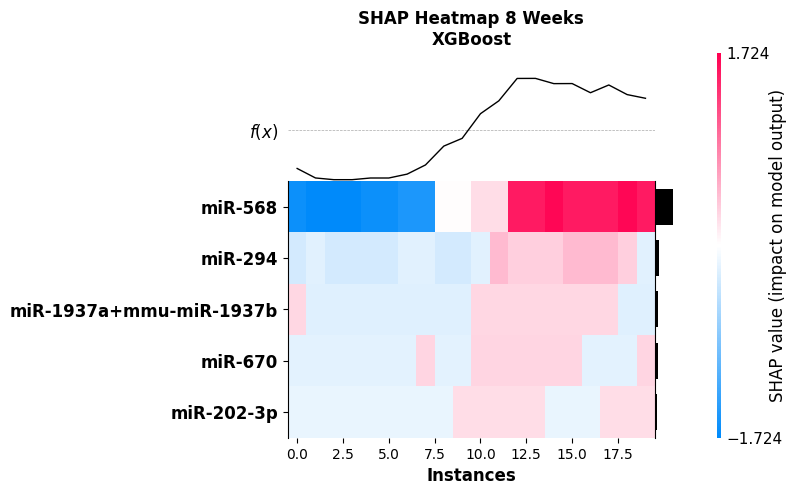

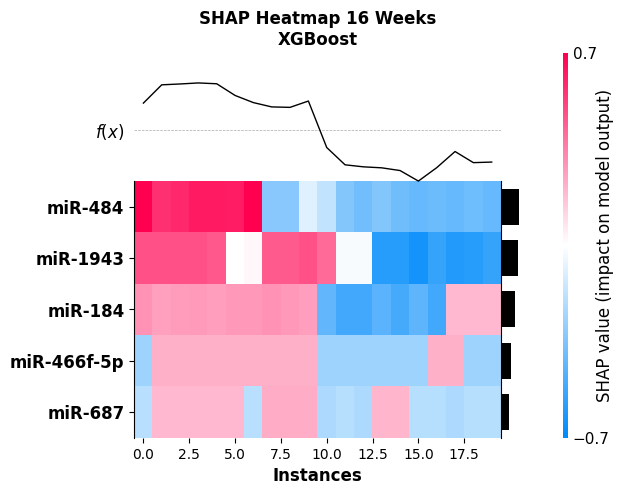

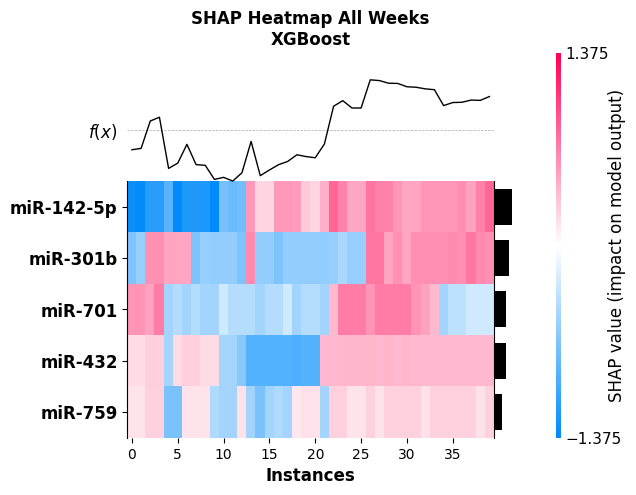

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [25]:
plot_shap_heatmap(
    top_shap_values(shap_values_8_weeks), 
    "SHAP Heatmap 8 Weeks\nXGBoost", 
    x_label='Instances',
    save_fig=True,
    file_name='td_xgboost_SHAP_Heatmap_8_Weeks.png'
)

plot_shap_heatmap(
    top_shap_values(shap_values_16_weeks), 
    "SHAP Heatmap 16 Weeks\nXGBoost", 
    x_label='Instances',
    save_fig=True,
    file_name='td_xgboost_SHAP_Heatmap_16_Weeks.png'
)

plot_shap_heatmap(
    top_shap_values(shap_values_all_weeks), 
    "SHAP Heatmap All Weeks\nXGBoost", 
    x_label='Instances',
    save_fig=True,
    file_name='td_xgboost_SHAP_Heatmap_All_Weeks.png'
)

## SHAP dependence plots

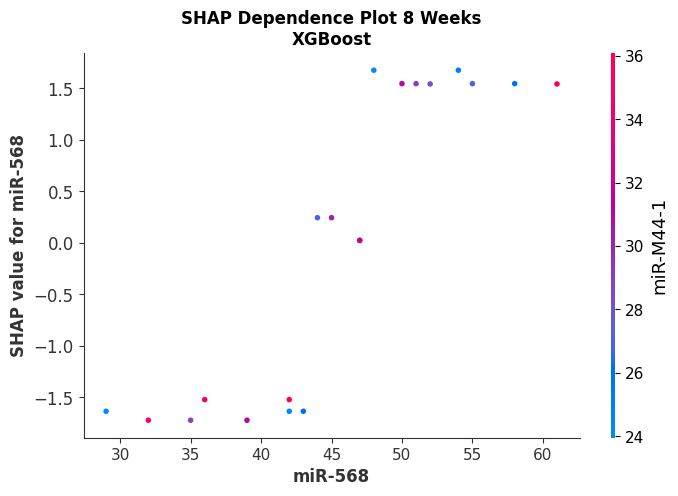

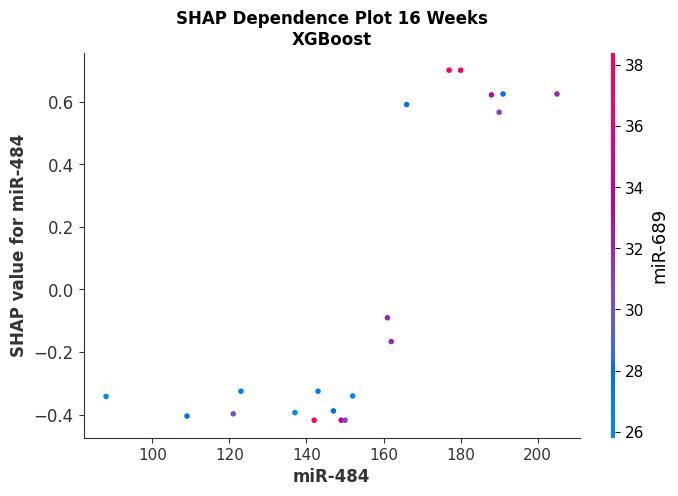

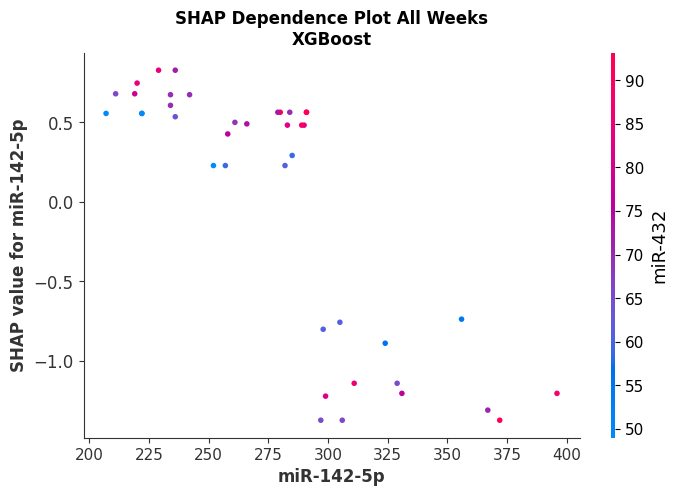

In [26]:
plot_shap_dependence(
    shap_values_8_weeks, 
    X_8_weeks, 
    "SHAP Dependence Plot 8 Weeks\nXGBoost", 
    save_fig=True,
    file_name='pg_xgboost_SHAP_Dependence_Plot_8_Weeks.png'
)

plot_shap_dependence(
    shap_values_16_weeks, 
    X_16_weeks, 
    "SHAP Dependence Plot 16 Weeks\nXGBoost", 
    save_fig=True,
    file_name='pg_xgboost_SHAP_Dependence_Plot_16_Weeks.png'
)

plot_shap_dependence(
    shap_values_all_weeks, 
    X_all_weeks, 
    "SHAP Dependence Plot All Weeks\nXGBoost", 
    save_fig=True,
    file_name='pg_xgboost_SHAP_Dependence_Plot_All_Weeks.png'
)